## 模型量化的简单实现
主要包括后量化（PTQ）和感知量化（QAT）  
作者：genggng  日期：2022年6月29日
资料来源：
- 知乎专栏：https://www.zhihu.com/column/c_1258047709686231040
- github仓库： https://github.com/Jermmy/pytorch-quantization-demo

### 1. 后量化的实现

量化的讲实数转为低比特的整数，转换公式为：
$$r= S(q-Z)$$
$$q=round(\frac{r}{S}+Z)$$
后量化的关键就是计算出scale（实数和整数的放缩比例）和zero point（实数0量化后对应的整数）.
$$S=\frac{r_{\max }-r_{\min }}{q_{\max }-q_{\min }}$$
$$ Z = round(q_{\max}-\frac{r_{max}}{S})$$
下面使用代码实现这两部分完成基本的tensor量化
当出现$Z>q_{\max}$或$Z<q_{\min}$ 时，需要对Z进行截断（因为Z也是用uint存储的)。
此时推导可知$r_{\max}<0$ 或 $r_{\min}>0$ ，因此应该**尽量避免tensor全为正数或者负数的情况**。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#### 基本量化操作的实现

In [2]:
def getScaleZeroPoint(min_val,max_val,num_bits=8):
    """
    计算量化参数scale和zero point
    @param
        min_val: 实数最大值
        max_val:  实数最小值
        num_bits:  量化位数
    
    @return
        scale: 实数整数放缩比例
        zero_point: 量化后的零点
    """
    #注意这里输入的mix_val，max_val是标量。
    q_min = 0.
    q_max = 2. ** num_bits - 1
    """
    这里主要是用到qmax和qmin的差值。
    实数和量化数的范围比例为scale，
    rmax放缩后的数和qmax差值就是zero point.
    所以q_min和q_max本身数值并不重要。
    """   
    scale = (max_val-min_val) / (q_max-q_min)
    zero_point = q_max - max_val/scale

    #为什么要截断zero_point?,因为零点也是用uint8存储的。
    if zero_point < q_min:
        zero_point = torch.tensor([q_min], dtype=torch.float32).to(min_val.device)
    elif zero_point > q_max:
        # zero_point = qmax
        zero_point = torch.tensor([q_max], dtype=torch.float32).to(max_val.device)
    
    zero_point.round_()

    return scale,zero_point

def quantize_tensor(x,scale,zero_point,num_bits=8,signed=False):
    """
    对张量x进行量化
    @param:
        x:待量化浮点数张量
        scale,zero_point:量化参数
        num_bits:量化位数
        signed:采用有符号量化
    @return:
        q_x:量化为整数的张量
    """
    if signed: #量化到有符号数[-128,127]
        q_min = - 2. ** (num_bits-1)
        q_max = 2. ** (num_bits-1) - 1
    else:  #量化到无符号数[0,255]
        q_min = 0.
        q_max = 2. ** num_bits - 1 
    
    q_x = x/scale + zero_point
    q_x.clamp_(q_min,q_max).round_() #使用pytorch内置函数进行截断和四舍五入取整。这一行相当于公式round函数

    return q_x

def dequantize_tensor(q_x,scale,zero_point):
    """
    将量化后的张量q_x反量化为浮点张量x
    @param:
        q_x:量化为整数的张量
        scale,zero_point:量化参数
    return:
        量化之前的浮点张量x
    """
    return scale * (q_x - zero_point) 

In [3]:
x = torch.tensor([-10.0,20.1,23.4,0.1,13.3])
scale,zero_point = getScaleZeroPoint(x.min(),x.max(),8)
q_x = quantize_tensor(x,scale,zero_point)
deq_x = dequantize_tensor(q_x,scale,zero_point)

print("scale={:.3f},zero_point={}".format(scale,zero_point))
print("q_x={}".format(q_x))
print("deq_x={}".format(deq_x))
print("error={}".format(deq_x-x))   #量化误差


scale=0.131,zero_point=76.0
q_x=tensor([  0., 229., 255.,  77., 178.])
deq_x=tensor([-9.9545, 20.0400, 23.4455,  0.1310, 13.3600])
error=tensor([ 0.0455, -0.0600,  0.0455,  0.0310,  0.0600])


#### 量化参数类的实现

我们在量化过程中，需要统计权重和激活值张量的max-min信息，并计算对应的scale和zero point，从而执行量化操作。  
我们可以将要保存的参数和要使用的量化操作封装为一个类，即量化参数。  
量化算法的关键也是量化参数的确定。

In [4]:
class QParam(nn.Module):
    # 就是将上面的代码进行了封装
    # 继承Module是为了让量化（参数）成为网络的一部分
    def __init__(self,num_bits=8):
        super().__init__()

        self.num_bits = num_bits
        scale = torch.tensor([], requires_grad=False)
        zero_point = torch.tensor([], requires_grad=False)
        min = torch.tensor([], requires_grad=False)
        max = torch.tensor([], requires_grad=False)
        
        # 使用register_buffer保存量化参数有以下优点：
        # 不产生梯度，不会被注册到parameters中，但也会保存到state_dict中
        # 这样就能把模型权重和量化参数都独立地保存到模型里。
        self.register_buffer('scale', scale)  
        self.register_buffer('zero_point', zero_point)
        self.register_buffer('min', min)
        self.register_buffer('max', max)
        
    def update(self,tensor):
        # 对于输入的待量化张量，更新对应的量化参数
        if self.max.nelement() == 0 or self.max <tensor.max():
            self.max.data = tensor.max().data   #使用data赋值，避免self.max对象本身
        self.max.clamp_(min=0)  #保证self.max大于等于0

        if self.min.nelement() == 0  or self.min >tensor.min():
            self.min.data = tensor.min().data
        self.min.clamp_(max=0)  #保证self.min小于等于0

        self.scale,self.zero_point = getScaleZeroPoint(self.min, self.max, self.num_bits)
    
    def quantize_tensor(self,tensor):
        return quantize_tensor(tensor,self.scale,self.zero_point,self.num_bits)
        
    def dequantize_tensor(self,q_x):
        return dequantize_tensor(q_x,self.scale,self.zero_point)

    # 从状态字典加载量化参数
    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict, missing_keys, unexpected_keys, error_msgs):
        key_names = ['scale', 'zero_point', 'min', 'max']
        for key in key_names:
            value = getattr(self, key)
            value.data = state_dict[prefix + key].data
            state_dict.pop(prefix + key)

    def __str__(self):
        info = 'scale:%.10f '  % self.scale
        info += 'zero_point:%d '  % self.zero_point
        info += 'min:%.6f '  % self.min
        info += 'max:%.6f'  % self.max
        return info


In [5]:
q_parm = QParam(num_bits=8)
x = torch.tensor([-10.0,20.1,23.4,0.1,13.3])
q_parm.update(x)
print("q_x=",q_parm.quantize_tensor(x))
print("q_parm:",q_parm)  #打印量化参数
print("q_parm state dict:",q_parm.state_dict()) #打印状态字典
torch.save(q_parm.state_dict(),"./q_parm.pt")# 保存状态字典

q_parm_new = QParam(num_bits=8)  #创建新的量化参数对象
q_parm_new.load_state_dict(torch.load("./q_parm.pt")) #从保存的状态字典中加载量化参数
print("q_parm_new",q_parm_new)  #打印量化参数，看是否一致

q_x= tensor([  0., 229., 255.,  77., 178.])
q_parm: scale:0.1309804022 zero_point:76 min:-10.000000 max:23.400000
q_parm state dict: OrderedDict([('scale', tensor(0.1310)), ('zero_point', tensor(76.)), ('min', tensor(-10.)), ('max', tensor(23.4000))])
q_parm_new scale:0.1309804022 zero_point:76 min:-10.000000 max:23.400000


#### 量化网络模块

上面我们能够实现对一个tensor进行量化，但仅仅实现了数据层面上的量化。  
我们还需要对神经网络的模块和运算进行量化，设置适用于量化的网络层。（conv,relu,maxpooling,fc等）


假设卷积的权重 weight 为 w，bias 为 b，输入为 x，输出的激活值为 a。由于卷积本质上就是矩阵运算，因此可以表示成:
$$ a=\sum_{i}^{N} w_{i} x_{i}+b$$  
量化公式为：
$$ S_{a}\left(q_{a}-Z_{a}\right)=\sum_{i}^{N} S_{w}\left(q_{w}-Z_{w}\right) S_{x}\left(q_{x}-Z_{x}\right)+S_{b}\left(q_{b}-Z_{b}\right)$$
$$ q_{a}=\frac{S_{w} S_{x}}{S_{a}} \sum_{i}^{N}\left(q_{w}-Z_{w}\right)\left(q_{x}-Z_{x}\right)+\frac{S_{b}}{S_{a}}\left(q_{b}-Z_{b}\right)+Z_{a}$$
其中令 $M=\frac{S_{w} S_{x}}{S_{a}}$ ,一般让$Z_{b}=0$则
$$q_{a} = M\left(\sum_{i}^{N} q_{w} q_{x}-\sum_{i}^{N} q_{w} Z_{x}-\sum_{i}^{N} q_{x} Z_{w}+\sum_{i}^{N} Z_{w} Z_{x}+q_{b}\right)+Z_{a}$$
从上面可以看出，除了x为动态输入，$q_{w}q_{x}$和$q_{w}Z_{x}$未知，其他的计算结果都可以提前确定下来。  
上面除了M是小数，其他都是整数，并且M可以通过bit shift的方法实现定点乘法。  
因此上式都可以使用整数定点运算完成。

In [6]:
from abc import abstractmethod
from torch.autograd import Variable
from torch.autograd import Function

import math

class QModule(nn.Module):
    # 创建各种网络模块基类,复用代码

    def __init__(self,qi=True,qo=True,num_bits=8):
        super().__init__()  #调用父类的构造函数
        """
        网络模块本质是待数据的算子， a = f(x),我们还需要输入x和输出a的量化参数
        但并不是算有模块都有输入，所以需要将上一层的qo作为本层的qi

        qi:这一层输入的量化参数，包括 S_x,Z_x
        qo: 这一层输出的量化参数,包括 S_a,Z_a
        """
        if qi:
            self.qi = QParam(num_bits=num_bits)
        if qo:
            self.qo = QParam(num_bits=num_bits)
        
    def freeze(self):
        # 将已经能计算出的静态结果冻结下来，并且由浮点实数转为定点整数
        pass

    @abstractmethod
    def quantize_inference(self,x):
        # 量化推理和正常推理过程不太一致，需要重新编写，因此定义为虚函数。
        raise NotImplemented("quantize_inference should be implemented.")

class FakeQuantize(Function):
    # 伪量化节点，进行量化和反量化
    # 模拟量化前后的误差，这样的float推理和量化后的int推理具有相同的精度

    # 反向传播求梯度使用STE，这部分在PTQ不进行反向传播，暂时可以忽略。  
    # Function类似于没有参数的Module，继承需要重写前向传播forward和反向传播backward
    @staticmethod
    def forward(ctx, x, qparam):
        """
        def forward(ctx,input,*args)
            ctx: 不需要手动传入，能够执行一些操作方便求梯度，例如：
            ctx.save_for_backward(tensor)  在前向传播时保存一些张量
            tensor = ctx.saved_tensors    在反向传播时（backward函数内）也可访问到

            input:函数的输入
            *args:其他可选参数
        """
        x = qparam.quantize_tensor(x)
        x = qparam.dequantize_tensor(x)
        return x

    @staticmethod
    def backward(ctx, grad_output):
        """
        grad_output:后一层传来的梯度

        在QAT涉及到反向传播
        对于本层（伪量化节点）,不计算梯度，直接把后一层的梯度往前传

        backward的返回值需要和forward对应，代表对应输入的梯度。
        由于q_parm为量化参数，不需要计算梯度，因此返回None
        因此直接 return grad_output，None
        """
        return grad_output, None


In [7]:
class QConv2d(QModule):
    # 二维卷积操作的量化版本
    def __init__(self,conv_module,qi=True,qo=True,num_bits=8):
        # 构造父类的属性
        super().__init__(qi=qi,qo=qo,num_bits=num_bits)
        self.conv_module = conv_module    #传入未量化的全精度卷积模块
        self.qw = QParam(num_bits=num_bits)  #卷积层权重的量化参数
        self.num_bits = num_bits
        M = torch.tensor([], requires_grad=False) # 将M注册为buffer
        self.register_buffer('M', M)  
    
    def freeze(self,qi=None,qo=None):
        # 为了计算公式中的M，q_w和q_b，并将其冻结

        # 量化卷积层要保证qi和qo都存在，且只被初始化过一次。
        if hasattr(self,'qi') and qi is not None:
            raise ValueError("qi has been provided in init function.")

        if not hasattr(self,'qi') and qi in None:
            raise ValueError("qi is not existed, should be provided.")
        
        if hasattr(self, 'qo') and qo is not None:
            raise ValueError('qo has been provided in init function.')

        if not hasattr(self, 'qo') and qo is None:
            raise ValueError('qo is not existed, should be provided.')
        
        if qi: self.qi = qi
        if qo: self.qo = qo

        # M = S_w*S_x / S_a 
        self.M.data = (self.qw.scale*self.qi.scale / self.qo.scale).data
        
        # 将卷积核参数q_w 量化为定点整数存储
        self.conv_module.weight.data = self.qw.quantize_tensor(self.conv_module.weight.data) 
        #  为什么减去zero_point? 其实就是对应公式里 q_w-Z_w
        self.conv_module.weight.data = self.conv_module.weight.data - self.qw.zero_point

        # 为了方便，使用S_w*S_x来代替S_b
        # 对bias使用对称量化，Z_b=0 (实数中的0和量化后的0相同)
        # 由于卷积运算结果通常使用32bit存储，因此bias也使用32位量化
        self.conv_module.bias.data = quantize_tensor(self.conv_module.bias.data,scale=self.qi.scale*self.qw.scale,zero_point=0,num_bits=32,signed=True)

    def forward(self,x):
        # 伪量化前向推理函数，适用于QAT中反向传播
        # 推理过程中顺便统计计算输入x，输出a，权重w的量化参数
        # 后量化通过数据校准实现这些。

        if hasattr(self,'qi'):
            self.qi.update(x)  #更新q_x的量化参数
            x = FakeQuantize.apply(x, self.qi)  #对q_x进行伪量化

        self.qw.update(self.conv_module.weight.data) #更新q_w的量化参数

        # 对卷积权重q_w进行伪量化，然后和x计算卷积操作
        # 注意卷积模块的权重始终是存储原始的weight，只有在前向传播时进行伪量化。
        # 反向传播时也是更新的量化前的weight
        x = F.conv2d(x, FakeQuantize.apply(self.conv_module.weight, self.qw), self.conv_module.bias, 
                     stride=self.conv_module.stride,
                     padding=self.conv_module.padding, dilation=self.conv_module.dilation, 
                     groups=self.conv_module.groups)

        x = self.conv_module(x)

        if hasattr(self,'op'):
            self.qo.update(x) #更新输出q_a的量化参数
            x = FakeQuantize.apply(x, self.qo)  #对输出a做伪量化
        
        return x
    
    def quantize_inference(self,x):
        # 将权重和激活值量化后的推理
        # 因为pytorch平台限制，这里使用float存储整数，进行浮点运算。
        # 实际部署时，应该所有数据和运算都采用定点整数（计算）
        x = x - self.qi.zero_point  #q_x - Z_x
        x = self.conv_module(x)    #(q_w-Z_w)*(q_x-Z_x)
        x = self.M * x             #M*sum((q_w-Z_w)*(q_x-Z_x))
        x.round_()                 #提前做一步round，加快速度。后面只剩下一个整数加法。
        x = x + self.qo.zero_point   #M*sum((q_w-Z_w)*(q_x-Z_x))+Z_a
        x.round_()
        return x

# 相同原理 实现其他网络模块
class QLinear(QModule):
    #量化线性层
    def __init__(self, fc_module, qi=True, qo=True, num_bits=8):
        super(QLinear, self).__init__(qi=qi, qo=qo, num_bits=num_bits)
        self.num_bits = num_bits
        self.fc_module = fc_module
        self.qw = QParam(num_bits=num_bits)
        M = torch.tensor([], requires_grad=False) # 将M注册为buffer
        self.register_buffer('M', M)  

    def freeze(self, qi=None, qo=None):

        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')

        if hasattr(self, 'qo') and qo is not None:
            raise ValueError('qo has been provided in init function.')
        if not hasattr(self, 'qo') and qo is None:
            raise ValueError('qo is not existed, should be provided.')

        if qi is not None:
            self.qi = qi
        if qo is not None:
            self.qo = qo

        self.M.data = (self.qw.scale*self.qi.scale / self.qo.scale).data
        # self.M = self.qw.scale * self.qi.scale / self.qo.scale

        self.fc_module.weight.data = self.qw.quantize_tensor(self.fc_module.weight.data)
        self.fc_module.weight.data = self.fc_module.weight.data - self.qw.zero_point
        self.fc_module.bias.data = quantize_tensor(self.fc_module.bias.data, scale=self.qi.scale * self.qw.scale,
                                                   zero_point=0, num_bits=32, signed=True)

    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        self.qw.update(self.fc_module.weight.data)

        x = F.linear(x, FakeQuantize.apply(self.fc_module.weight, self.qw), self.fc_module.bias)

        if hasattr(self, 'qo'):
            self.qo.update(x)
            x = FakeQuantize.apply(x, self.qo)

        return x

    def quantize_inference(self, x):
        x = x - self.qi.zero_point
        x = self.fc_module(x)
        x = self.M * x
        x.round_() 
        x = x + self.qo.zero_point
        x.clamp_(0., 2.**self.num_bits-1.).round_()
        return x


class QReLU(QModule):
    # 构建量化版的Relu函数
    def __init__(self, qi=False, num_bits=None):
        super(QReLU, self).__init__(qi=qi, num_bits=num_bits)

    def freeze(self, qi=None):
        
        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')

        if qi is not None:
            self.qi = qi

    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        x = F.relu(x)

        return x
    
    def quantize_inference(self, x):
        x = x.clone()
        x[x < self.qi.zero_point] = self.qi.zero_point
        return x

class QMaxPooling2d(QModule):
    # 构建量化版的MaxPooling2d函数
    def __init__(self, kernel_size=3, stride=1, padding=0, qi=False, num_bits=None):
        super(QMaxPooling2d, self).__init__(qi=qi, num_bits=num_bits)
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def freeze(self, qi=None):
        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')
        if qi is not None:
            self.qi = qi

    def forward(self, x):
        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        x = F.max_pool2d(x, self.kernel_size, self.stride, self.padding)

        return x

    def quantize_inference(self, x):
        return F.max_pool2d(x, self.kernel_size, self.stride, self.padding)


#### Conv-BN-Relu融合层的实现
一个标准的Conv+BN+relu可以合并到一起，加快推理速度。
- **BN折叠到卷积层**  
卷积层的输出如下所示:  $$y=\sum_{i}^{N} w_{i} x_{i}+b$$
BN层的输出如下所示:  
$$y_{bn} =\gamma \frac{y-\mu_{y}}{\sqrt{\sigma_{y}^{2}+\epsilon}}+\beta$$
将卷积层的输出$y$带入到BN层中得到：  
$$y_{b n}=\frac{\gamma}{\sqrt{\sigma_{y}^{2}+\epsilon}}\left(\sum_{i}^{N} w_{i} x_{i}+b-\mu_{y}\right)+\beta$$
仔细观察，当训练结束后，BN层统计量$\mu_{y}$ ,$\sigma_{y}$以及参数$\gamma$, $\beta$都已经固定下来。我们可以令$\gamma^{\prime}=\frac{\gamma}{\sqrt{\sigma_{y}^{2}+\epsilon}}$,那么能够得到：
$$y_{b n}=\sum_{i}^{N} \gamma^{\prime} w_{i} x_{i}+\gamma^{\prime}\left(b-\mu_{y}\right)+\beta$$
上式已经和卷积计算公式非常像了，为了看得更清楚，我们令$w_{i}^{\prime} = \gamma^{\prime}w_{i}$,  $b^{\prime}=\gamma^{\prime}\left(b-\mu_{y}\right)+\beta$,得到最终的BN层输出
 $$y_{bn}=\sum_{i}^{N} w_{i} x_{i}^{\prime}+b^{\prime}$$
这就和卷积的操作一模一样，因此我们可以把BN层折叠合并到卷积层中。先进行数值变换，在进行矩阵运算。

- **Relu折叠到卷积层**  
1. 在量化中，Conv + ReLU 这样的结构一般也是合并成一个 Conv 进行运算的，而这一点在全精度模型中则办不到。  
2. 要想保证浮点型Relu和量化型Relu数值的一致性，需要对输入输出使用相同的量化参数,否则无法反量化回正确的实数域。  
3. relu会对数值进行截断，实际上在量化过程中也存在截断，就是把scale和偏移zero point后的值截断到（qmin,qmax）。  
4. 对于单独的一个Relu层，我们可以直接使用输入的qi在量化数值空间做截断，$relu(q_{x}) = max(q_{x},Z_{x})$。
5. 对于合并到conv中的relu层，我们可以使用**输出的qo作为量化参数，对relu的输入x进行量化**，量化的截断过程可以直接实现relu的操作。这是因为在float域，relu的值域是[0,r_max]，对应的量化值域就是[q_min,q_max]。relu函数在float域中，对小于0的数置为0；在量化int域中，就是对小于q_min的数置为q_min。而使用qo对x进行量化，就能保证这一点。




In [41]:
class QConvBNReLU(QModule):
    # 构建量化BN层（与Relu融合）
    def __init__(self, conv_module, bn_module, qi=True, qo=True, num_bits=8):
        super(QConvBNReLU, self).__init__(qi=qi, qo=qo, num_bits=num_bits)
        self.num_bits = num_bits
        self.conv_module = conv_module
        self.bn_module = bn_module
        self.qw = QParam(num_bits=num_bits)
        self.qb = QParam(num_bits=32)
        M = torch.tensor([], requires_grad=False) # 将M注册为buffer
        self.register_buffer('M', M)  

    def fold_bn(self, mean, std):
        # 将BN层折叠到Conv层
        if self.bn_module.affine:
            gamma_ = self.bn_module.weight / std  #r' = r/ sqrt(sigma^2+e)  实际上除以的标准差，加上e是为了避免分母为零
            weight = self.conv_module.weight * gamma_.view(self.conv_module.out_channels, 1, 1, 1) #w' = r'*w
            if self.conv_module.bias is not None:         # b' = r' * b - r' * mu_y + beta
                bias = gamma_ * self.conv_module.bias - gamma_ * mean + self.bn_module.bias
            else:
                bias = self.bn_module.bias - gamma_ * mean
        else:
            gamma_ = 1 / std
            weight = self.conv_module.weight * gamma_
            if self.conv_module.bias is not None:
                bias = gamma_ * self.conv_module.bias - gamma_ * mean
            else:
                bias = -gamma_ * mean
            
        return weight, bias    #返回新的w和b


    def forward(self, x):

        if hasattr(self, 'qi'):
            self.qi.update(x)
            x = FakeQuantize.apply(x, self.qi)

        # 训练过程中，更新BN层参数
        if self.training:
            y = F.conv2d(x, self.conv_module.weight, self.conv_module.bias, 
                            stride=self.conv_module.stride,
                            padding=self.conv_module.padding,
                            dilation=self.conv_module.dilation,
                            groups=self.conv_module.groups)
            y = y.permute(1, 0, 2, 3) # NCHW -> CNHW
            y = y.contiguous().view(self.conv_module.out_channels, -1) # CNHW -> C,NHW
            # mean = y.mean(1)
            # var = y.var(1)
            mean = y.mean(1).detach()
            var = y.var(1).detach()
            self.bn_module.running_mean = \
                self.bn_module.momentum * self.bn_module.running_mean + \
                (1 - self.bn_module.momentum) * mean
            self.bn_module.running_var = \
                self.bn_module.momentum * self.bn_module.running_var + \
                (1 - self.bn_module.momentum) * var
        else:
            mean = Variable(self.bn_module.running_mean)
            var = Variable(self.bn_module.running_var)

        std = torch.sqrt(var + self.bn_module.eps)

        weight, bias = self.fold_bn(mean, std)  #折叠后的w和b

        self.qw.update(weight.data)

        #这里的卷积运算实际上包含了BN层
        x = F.conv2d(x, FakeQuantize.apply(weight, self.qw), bias, 
                stride=self.conv_module.stride,
                padding=self.conv_module.padding, dilation=self.conv_module.dilation, 
                groups=self.conv_module.groups)

        x = F.relu(x)    #后面接上relu函数

        if hasattr(self, 'qo'):
            self.qo.update(x)
            x = FakeQuantize.apply(x, self.qo)

        return x

    def freeze(self, qi=None, qo=None):
        if hasattr(self, 'qi') and qi is not None:
            raise ValueError('qi has been provided in init function.')
        if not hasattr(self, 'qi') and qi is None:
            raise ValueError('qi is not existed, should be provided.')

        if hasattr(self, 'qo') and qo is not None:
            raise ValueError('qo has been provided in init function.')
        if not hasattr(self, 'qo') and qo is None:
            raise ValueError('qo is not existed, should be provided.')

        if qi is not None:
            self.qi = qi
        if qo is not None:
            self.qo = qo

        self.M.data = (self.qw.scale*self.qi.scale / self.qo.scale).data
        # self.M = self.qw.scale * self.qi.scale / self.qo.scale

        std = torch.sqrt(self.bn_module.running_var + self.bn_module.eps)

        weight, bias = self.fold_bn(self.bn_module.running_mean, std)
        self.conv_module.weight.data = self.qw.quantize_tensor(weight.data)
        self.conv_module.weight.data = self.conv_module.weight.data - self.qw.zero_point

        self.conv_module.bias.data = quantize_tensor(bias, scale=self.qi.scale * self.qw.scale,
                                                     zero_point=0, num_bits=32, signed=True)

    def quantize_inference(self, x):
        x = x - self.qi.zero_point
        x = self.conv_module(x)
        x = self.M * x
        x.round_() 
        x = x + self.qo.zero_point
        
        #推理时将Relu合并到量化过程
        #这一行包含了relu函数的作用，将x截断到(qmin,qmax)非对称量化         
        x.clamp_(0., 2.**self.num_bits-1.).round_()  
        return x

#### 量化模型的构建
我们在上面已经得到了基本的网络模块（卷积、池化、线性层等）的量化版本，  
现在我们尝试构建一个完整的带有BN层的量化模型。

In [9]:
class NetBN(nn.Module):

    # 定义简单的卷积神经网络，包含两层卷积、2层BN层，1层全连接层
    def __init__(self, num_channels=1):
        super(NetBN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 40, 3, 1)
        self.bn1 = nn.BatchNorm2d(40)
        self.conv2 = nn.Conv2d(40, 40, 3, 1)
        self.bn2 = nn.BatchNorm2d(40)
        self.fc = nn.Linear(5 * 5 * 40, 10)

    # 普通的全精度前向传播，穿插了2次relu函数和最大池化操作
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5 * 5 * 40)
        x = self.fc(x)
        return x
    
    # 我们需要把卷积层、池化层、全连接层转为其量化版本
    def quantize(self, num_bits=8):
        self.qconv1 = QConvBNReLU(self.conv1, self.bn1, qi=True, qo=True, num_bits=num_bits)
        self.qmaxpool2d_1 = QMaxPooling2d(kernel_size=2, stride=2, padding=0)
        self.qconv2 = QConvBNReLU(self.conv2, self.bn2, qi=False, qo=True, num_bits=num_bits)
        self.qmaxpool2d_2 = QMaxPooling2d(kernel_size=2, stride=2, padding=0)
        self.qfc = QLinear(self.fc, qi=False, qo=True, num_bits=num_bits)

    # 量化版本的前向传播，就是各量化网络模块forward的串行堆叠
    def quantize_forward(self, x):
        x = self.qconv1(x)
        x = self.qmaxpool2d_1(x)
        x = self.qconv2(x)
        x = self.qmaxpool2d_2(x)
        x = x.view(-1, 5*5*40)
        x = self.qfc(x)
        return x

    # 对各种量化参数进行固定
    # 除了第一层卷积需要qi，其他都是对上一层的qo复用为当前层的qi，因为上一层的输出就是这一层的输入。
    # 这里可以优化，伪量化过程中，这一层输出与下一层输入是一个tensor，但是执行了两次统计。
    def freeze(self):
        self.qconv1.freeze()
        self.qmaxpool2d_1.freeze(self.qconv1.qo)
        self.qconv2.freeze(qi=self.qconv1.qo)
        self.qmaxpool2d_2.freeze(self.qconv2.qo)
        self.qfc.freeze(qi=self.qconv2.qo)

    # 实际推理中用到的函数，是对各量化模块的quantize_inference的堆叠，纯整数存储和运算
    def quantize_inference(self, x):
        qx = self.qconv1.qi.quantize_tensor(x) #对最开始的float输入进行量化

        """
        中间推理都是在int域进行， 配合量化参数进行前向传播。
        伪量化是在float域进行，虽有本质不同，但最终与int域反量化结果一致。
        """
        qx = self.qconv1.quantize_inference(qx)    
        qx = self.qmaxpool2d_1.quantize_inference(qx)
        qx = self.qconv2.quantize_inference(qx)
        qx = self.qmaxpool2d_2.quantize_inference(qx)
        qx = qx.view(-1, 5*5*40)

        qx = self.qfc.quantize_inference(qx)
        
        out = self.qfc.qo.dequantize_tensor(qx)   #最后一步要反量化，得到实数域的结果
        return out


#### 全精度模型训练
这里直接使用仓库提供的 *train.py* 得到在mnist数据集上准确率为99%的FP32模型，权重保存在 *./ckpt/mnist_cnnbn.pt*  
```shell
python ./train.py
```

#### 后训练量化（PTQ）
这里会将一个全精度模型转为一个量化模型，并且测试其精度。

In [10]:
# 加载训练好的全精度模型
fp32_model = NetBN()
fp32_model.load_state_dict(torch.load("./ckpt/mnist_cnnbn.pt"))

<All keys matched successfully>

这里是几个用于测试精度的工具函数

In [11]:
# 使用一定的图片数据进行校准，确定input和中间activation的量化参数
# 实际上模型weight的校准并不需要数据，这里为了方便都放在quantize_forward中进行校准
from torchvision import datasets,transforms
test_batch_size = 64

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, num_workers=1, pin_memory=True
)


def direct_quantize(model, test_loader):
    # 直接量化，使用一些数据集来校准量化参数,使用200个batch的数据
    for i, (data, target) in enumerate(test_loader, 1):
        output = model.quantize_forward(data)
        if i % 200 == 0:
            break
    print('direct quantization finish')

def full_inference(model, test_loader):
    # 全精度模型测试准确率
    correct = 0
    for i, (data, target) in enumerate(test_loader, 1):
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    print('\nTest set: Full Model Accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

def quantize_inference(model, test_loader):
    # 量化模型测试准确率
    correct = 0
    for i, (data, target) in enumerate(test_loader, 1):
        # data,target = data.to(device),target.to(device)
        output = model.quantize_inference(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Quant Model Accuracy: {:.0f}%\n'.format(acc))
    return acc


In [12]:
fp32_model.eval()
full_inference(fp32_model,test_loader)  #测试全精度的准确率


Test set: Full Model Accuracy: 99%



In [13]:
import copy
accuracy_list = []
for num_bits in range(1,9):  #测试num_bits=[1-8]的准确率
    model = copy.deepcopy(fp32_model)
    model.quantize(num_bits=num_bits) # 将模型的各个网络模块转为其量化版本
    model.eval()
    direct_quantize(model,test_loader)  #进行量化校准
    model.freeze()                       # 将量化参数固定
    print("num_bits",num_bits)
    acc = quantize_inference(model, test_loader)  #测试量化准确率
    accuracy_list.append(acc)

direct quantization finish
num_bits 1

Test set: Quant Model Accuracy: 10%

direct quantization finish
num_bits 2

Test set: Quant Model Accuracy: 29%

direct quantization finish
num_bits 3

Test set: Quant Model Accuracy: 79%

direct quantization finish
num_bits 4

Test set: Quant Model Accuracy: 98%

direct quantization finish
num_bits 5

Test set: Quant Model Accuracy: 99%

direct quantization finish
num_bits 6

Test set: Quant Model Accuracy: 99%

direct quantization finish
num_bits 7

Test set: Quant Model Accuracy: 99%

direct quantization finish
num_bits 8

Test set: Quant Model Accuracy: 99%



<AxesSubplot:>

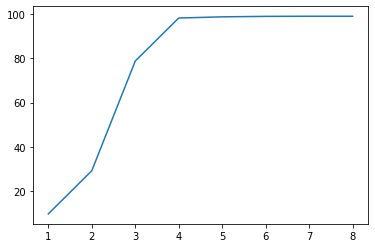

In [14]:
import pandas as pd
acc_quants = pd.Series(accuracy_list,index=list(range(1,9)))
acc_quants.plot()  #不同num_bits下的量化准确率

从上图可以看出，当num_bits=4时，量化基本已经达到最大准确率99%。  
这说明使用fp32存储这个小模型实在是浪费，使用int4即可。

### 2.量化感知训练（QAT）

#### 量化模型训练的问题
量化模型我们插入了伪量化节点，经过反量化和量化，能够模拟量化带来的数值误差，实际存储的是反量化的float数值。  
但是这样的模型还是不能训练，因为在计算图中，量化操作存在round函数（取整函数），这个函数**梯度几乎处处为0**。  
这样我们就会导致反向传播的中梯度为0（链式法则），无法完成训练。  
我们可以使用STE尝试解决这个问题。  
#### Straight Through Estimator
STE方式是，直接跳过伪量化的过程，避开round操作。直接把卷积层的梯度回传到伪量化之前的 weight 上。这样一来，由于卷积中用的 weight 是经过伪量化操作的，因此可以模拟量化误差，把这些误差的梯度回传到原来的 weight，又可以更新权重，使其适应量化产生的误差，量化训练就可以正常进行下去了。  
关键点：对weight伪量化会带来误差，从而降低模型精度。通过反向传播把梯度传给伪量化前的weight，并且**更新伪量化前的weight**， 使其适应量化带来的误差。这就是量化感知训练。

In [15]:
# 量化感知训练的过程，和普通训练模型没什么差异
# 更新的也是量化前weight，伪量化操作只在前向传播中使用引入量化误差，本身并不会修改weight
def quantize_aware_training(model, device, train_loader, optimizer, epoch):
    lossLayer = torch.nn.CrossEntropyLoss()
    for batch_idx, (data, target) in enumerate(train_loader, 1):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.quantize_forward(data)
        loss = lossLayer(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 50 == 0:
            print('Quantize Aware Training Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()
            ))

In [16]:
# 进行量化感知训练
from torch import optim
batch_size = 64
seed = 1
epochs = 3
lr = 0.01
momentum = 0.9
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, 
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=False
)

model_qat = copy.deepcopy(fp32_model)  #从全精度模型获得量化模型
model_qat.quantize(num_bits=3)  #量化位数为3
model_qat.to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
model_qat.train()
for epoch in range(epochs):
    quantize_aware_training(model_qat,device,train_loader,optimizer,epoch+1)
model_qat.eval()
model_qat.freeze() #冻结量化参数

Quantize Aware Training Epoch: 1 [3200/60000]	Loss: 0.366943
Quantize Aware Training Epoch: 1 [6400/60000]	Loss: 0.412441
Quantize Aware Training Epoch: 1 [9600/60000]	Loss: 0.301458
Quantize Aware Training Epoch: 1 [12800/60000]	Loss: 0.271548
Quantize Aware Training Epoch: 1 [16000/60000]	Loss: 0.350231
Quantize Aware Training Epoch: 1 [19200/60000]	Loss: 0.268980
Quantize Aware Training Epoch: 1 [22400/60000]	Loss: 0.465458
Quantize Aware Training Epoch: 1 [25600/60000]	Loss: 0.277720
Quantize Aware Training Epoch: 1 [28800/60000]	Loss: 0.408366
Quantize Aware Training Epoch: 1 [32000/60000]	Loss: 0.136120
Quantize Aware Training Epoch: 1 [35200/60000]	Loss: 0.270865
Quantize Aware Training Epoch: 1 [38400/60000]	Loss: 0.416413
Quantize Aware Training Epoch: 1 [41600/60000]	Loss: 0.326923
Quantize Aware Training Epoch: 1 [44800/60000]	Loss: 0.324175
Quantize Aware Training Epoch: 1 [48000/60000]	Loss: 0.320476
Quantize Aware Training Epoch: 1 [51200/60000]	Loss: 0.127868
Quantize Aw

In [18]:
model_qat.cpu()
quantize_inference(model_qat, test_loader)


Test set: Quant Model Accuracy: 83%



82.87

在num_bits=3时，PTQ就有84%的准确率，而QAT只有74%的准确率，还不如直接量化呢。

### 3.网络性能分析

In [ ]:
import torch.profiler
import torch
import tqdm

In [ ]:
# 构建追踪的属性
model.eval() #测试量化感知模型的性能

with torch.profiler.profiler(
    schedule = torch.profiler.schedule(wait=2,warmup=2,active=6,repeat=1),
    on_trace_ready = torch.profiler.tensorboard_trace_handler(dir_name="./performance/"),  #日志保存地址
    activities = [
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA
    ],
    with_stack = True,
) as profiler:
    with torch.no_grad():
        for batch_idx in tqdm(test_loader,desc="profiling..."):  #这里用假数据也行，不考虑模型预测精度
            pass

In [ ]:
next(model.qconv1.qi.buffers())

tensor(0.0127)

device(type='cpu')

In [38]:
model_qat = copy.deepcopy(fp32_model)  
model_qat.quantize(num_bits=3)  #量化位数为3

In [32]:
model_qat.cpu()

NetBN(
  (conv1): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=1000, out_features=10, bias=True)
  (qconv1): QConvBNReLU(
    (qi): QParam()
    (qo): QParam()
    (conv_module): Conv2d(1, 40, kernel_size=(3, 3), stride=(1, 1))
    (bn_module): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (qw): QParam()
    (qb): QParam()
  )
  (qmaxpool2d_1): QMaxPooling2d(
    (qo): QParam()
  )
  (qconv2): QConvBNReLU(
    (qo): QParam()
    (conv_module): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1))
    (bn_module): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (qw): QParam()
    (qb): QParam()
  )
  (qmaxpool2d_2): QMaxPooling2d(
    (qo): QParam()
  )

In [39]:
next(model_qat.parameters()).device


device(type='cpu')

In [40]:
model_qat.qconv1.M.device

AttributeError: 'QConvBNReLU' object has no attribute 'M'